In [22]:
import pandas as pd
import os
import cv2
import numpy as np
import math
import albumentations as A
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
from torch.utils.data import ConcatDataset
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou
import zipfile
import os
# from google.colab import files
from sklearn.metrics import precision_recall_fscore_support


In [23]:

image_dir = "/kaggle/input/aggregate-dataset-exam-cheatdetection/Custom_Data/Train/images"
label_dir = "/kaggle/input/aggregate-dataset-exam-cheatdetection/Custom_Data/Train/labels"
img_shape = (320,320)
RESIZE_SHAPE = (320, 320)

In [24]:
Transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.2),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.3),
        A.RGBShift(p=0.2),
        A.CLAHE(p=0.1),
        A.GaussNoise(std_range=(0.1, 0.2), p=0.5),
        A.ISONoise(p=0.2),
        A.MotionBlur(blur_limit=5, p=0.5),
        A.MedianBlur(blur_limit=3, p=0.4),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.RandomScale(scale_limit=0.1, p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, border_mode=0, p=0.4),

        # Adaptive padding and cropping
        A.PadIfNeeded(min_height=320, min_width=320, border_mode=0),
        A.RandomCrop(height=320, width=320, p=0.8),
        A.Resize(height=320, width=320, p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

resize_transform = A.Compose([  A.PadIfNeeded(min_height=320, min_width=320, border_mode=0),
        A.RandomCrop(height=320, width=320, p=0.8),
        A.Resize(height=320, width=320, p=1.0)],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [25]:
class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width, _ = image.shape

        # Load labels
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_filename)[0] + ".txt")
        bboxes, class_labels = [], []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x_c, y_c, w, h = map(float, line.strip().split())
                    x_min = max((x_c - w/2) * original_width, 0)
                    y_min = max((y_c - h/2) * original_height, 0)
                    x_max = min((x_c + w/2) * original_width, original_width - 1)
                    y_max = min((y_c + h/2) * original_height, original_height - 1)
                    # Filter invalid boxes
                    if x_max > x_min and y_max > y_min:
                        bboxes.append([x_min, y_min, x_max, y_max])
                        class_labels.append(int(class_id))

        # Apply transforms if available
        if self.transform and len(bboxes) > 0:
            try:
                transformed = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
                image = transformed['image']
                bboxes = transformed['bboxes']
                class_labels = transformed['class_labels']
            except ValueError as e:
                valid_bboxes, valid_labels = [], []
                for bbox, label in zip(bboxes, class_labels):
                    x_min, y_min, x_max, y_max = bbox
                    if x_max > x_min and y_max > y_min:
                        valid_bboxes.append(bbox)
                        valid_labels.append(label)
                if len(valid_bboxes) > 0:
                    try:
                        transformed = self.transform(image=image, bboxes=valid_bboxes, class_labels=valid_labels)
                        image = transformed['image']
                        bboxes = transformed['bboxes']
                        class_labels = transformed['class_labels']
                    except ValueError:

                        pass


        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))  # HWC → CHW
        image = torch.tensor(image, dtype=torch.float32)


        current_height, current_width = image.shape[1], image.shape[2]
        image = TF.resize(image, RESIZE_SHAPE)
        new_height, new_width = RESIZE_SHAPE


        scale_x = new_width / current_width
        scale_y = new_height / current_height


        scaled_bboxes = []
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            scaled_x_min = x_min * scale_x
            scaled_y_min = y_min * scale_y
            scaled_x_max = x_max * scale_x
            scaled_y_max = y_max * scale_y

            # Clamp to image boundaries
            scaled_x_min = max(0, min(scaled_x_min, new_width - 1))
            scaled_y_min = max(0, min(scaled_y_min, new_height - 1))
            scaled_x_max = max(0, min(scaled_x_max, new_width - 1))
            scaled_y_max = max(0, min(scaled_y_max, new_height - 1))


            if scaled_x_max > scaled_x_min and scaled_y_max > scaled_y_min:
                scaled_bboxes.append([scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max])
            else:

                class_labels.pop(len(scaled_bboxes))


        targets = []
        for box, label in zip(scaled_bboxes, class_labels):
            targets.append([label] + list(box))
        targets = torch.tensor(targets, dtype=torch.float32) if targets else torch.zeros((0, 5), dtype=torch.float32)

        return image, targets

In [26]:
class ConcatDatasets(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            return self.dataset1[idx]
        else:
            return self.dataset2[idx - len(self.dataset1)]

In [27]:

base_dataset = YOLODataset(
    images_dir=image_dir,
    labels_dir=label_dir,
)

transformed_dataset = YOLODataset(
    images_dir=image_dir,
    labels_dir=label_dir,
    transform=Transform
)

doubled_dataset = ConcatDatasets(base_dataset, transformed_dataset)

print("The number of images in this Doubled dataset is ",len(doubled_dataset))
train_size = int(0.8 * len(doubled_dataset))
val_size = len(doubled_dataset) - train_size
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    return images, list(targets)

train_dataset, val_dataset = random_split(doubled_dataset, [train_size, val_size])
dataloader = DataLoader(doubled_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn
)

The number of images in this Doubled dataset is  9764


In [28]:

class DetectionLoss(nn.Module):
    def __init__(self):
        super(DetectionLoss, self).__init__()
        self.class_loss_fn = nn.BCEWithLogitsLoss()
        self.bbox_loss_fn = nn.SmoothL1Loss()

    def forward(self, predictions, targets):
        """
        predictions: [B, K, 5]
        targets: list of [N_i, 5] tensors
        """
        B, K, _ = predictions.shape
        pred_scores = predictions[:, :, 0]       # [B, K]
        pred_boxes = predictions[:, :, 1:5]      # [B, K, 4]

        true_labels = torch.zeros((B, K), device=predictions.device)
        true_boxes = torch.zeros((B, K, 4), device=predictions.device)

        for i, t in enumerate(targets):
            num_objs = min(K, t.shape[0])
            if num_objs > 0:
                true_labels[i, :num_objs] = t[:num_objs, 0]
                true_boxes[i, :num_objs] = t[:num_objs, 1:5]

        class_loss = self.class_loss_fn(pred_scores, true_labels)
        bbox_loss = self.bbox_loss_fn(pred_boxes, true_boxes)

        return class_loss + bbox_loss

class EarlyStopping:
    def __init__(self, patience=5, restore_best_weights=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.restore_best_weights = restore_best_weights
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_state is not None:
                    model.load_state_dict(self.best_model_state)

def save_checkpoint(model, epoch, val_metric, best_metric, path='best_model.pth'):
    if val_metric > best_metric:
        print(f"Validation metric improved ({best_metric:.4f} → {val_metric:.4f}). Saving model.")
        torch.save(model.state_dict(), path)
        return val_metric
    return best_metric



In [29]:
# cnn

class ObjectDetectionCNN(nn.Module):
    def __init__(self, input_channels=3, num_predictions=2):
        super(ObjectDetectionCNN, self).__init__()

        def conv_block(in_channels, out_channels, num_convs, pool=True):
            layers = []
            for _ in range(num_convs):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            if pool:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_block(input_channels, 64, num_convs=2),
            conv_block(64, 128, num_convs=2),
            conv_block(128, 256, num_convs=4),
            conv_block(256, 512, num_convs=4),
            conv_block(512, 512, num_convs=4),
        )

        self.adapt_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_predictions * 5)
        )
        self.num_predictions = num_predictions

    def forward(self, x):
        x = self.features(x)
        x = self.adapt_pool(x)
        x = self.classifier(x)
        x = x.view(x.shape[0], self.num_predictions, 5)
        return x

In [ ]:

#Resnet Pretrained

import torchvision.models as models
class ObjectDetectionResNet(nn.Module):
    def __init__(self, num_predictions=2):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_predictions * 5)
        )
        self.num_predictions = num_predictions

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        x = x.view(x.shape[0], self.num_predictions, 5)
        return x

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ObjectDetectionResNet().to(device)
num_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DetectionLoss()
early_stopping = EarlyStopping(patience=2, restore_best_weights=True)
best_val_loss = float('inf')
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_images, batch_targets in dataloader:
        batch_images = batch_images.to(device)
        batch_targets = [t.to(device) for t in batch_targets]
        outputs = model(batch_images)
        loss = criterion(outputs, batch_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_images, val_targets in val_loader:
            val_images = val_images.to(device)
            val_targets = [t.to(device) for t in val_targets]

            outputs = model(val_images)
            loss = criterion(outputs, val_targets)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(dataloader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # Reduce LR on plateau
    scheduler.step(avg_val_loss)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


Epoch 1: Train Loss = 51.7921, Val Loss = 42.9663
Epoch 2: Train Loss = 42.9230, Val Loss = 39.6068
Epoch 3: Train Loss = 39.9983, Val Loss = 36.7061
Epoch 4: Train Loss = 38.0761, Val Loss = 33.5533
Epoch 5: Train Loss = 36.3480, Val Loss = 33.4295
Epoch 6: Train Loss = 35.4298, Val Loss = 32.5889
Epoch 7: Train Loss = 34.5966, Val Loss = 31.4020
Epoch 8: Train Loss = 33.8425, Val Loss = 30.5189
Epoch 9: Train Loss = 33.4145, Val Loss = 32.1169
Epoch 10: Train Loss = 32.4009, Val Loss = 30.3528
Epoch 11: Train Loss = 31.9449, Val Loss = 29.8816
Epoch 12: Train Loss = 31.4270, Val Loss = 28.1882
Epoch 13: Train Loss = 31.0956, Val Loss = 28.5230
Epoch 14: Train Loss = 30.1825, Val Loss = 27.0505
Epoch 15: Train Loss = 29.6865, Val Loss = 27.0708
Epoch 16: Train Loss = 29.2448, Val Loss = 26.8988
Epoch 17: Train Loss = 28.9618, Val Loss = 25.6891
Epoch 18: Train Loss = 28.4587, Val Loss = 26.8172
Epoch 19: Train Loss = 28.1504, Val Loss = 26.3888
Early stopping triggered.


In [36]:
def draw_boxes(image, boxes, labels, color=(0, 255, 0), label_prefix=""):
    """Draw bounding boxes and labels on image"""
    image = image.copy()
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{label_prefix}{label}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return image

def add_prediction_status(image, is_correct, position='top'):
    """Add prediction status text to image"""
    image = image.copy()
    status_text = "CORRECT PREDICTION" if is_correct else "INCORRECT PREDICTION"
    color = (0, 255, 0) if is_correct else (0, 0, 255)


    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    thickness = 2
    (text_width, text_height), baseline = cv2.getTextSize(status_text, font, font_scale, thickness)

    if position == 'top':
        x = (image.shape[1] - text_width) // 2
        y = text_height + 10
    else:
        x = (image.shape[1] - text_width) // 2
        y = image.shape[0] - 10


    cv2.rectangle(image, (x-5, y-text_height-5), (x+text_width+5, y+baseline+5), (255, 255, 255), -1)
    cv2.putText(image, status_text, (x, y), font, font_scale, color, thickness)

    return image

import os
import torch
import numpy as np
import cv2
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model_binary(model, test_loader, device, threshold=0.5, save_dir="pred_vs_true", max_images=100):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    y_true = []
    y_pred = []
    saved_count = 0

    print(f"Evaluating... (threshold={threshold})")

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets)):

                if isinstance(target, torch.Tensor):
                    target = target.to(device)
                    true_class = 1 if (target.ndim == 2 and target.shape[0] > 0 and target[0, 0].item() > 0.5) else 0
                else:
                    continue


                pred_objectness = torch.sigmoid(output[0, 0]).item()
                pred_class = 1 if pred_objectness > threshold else 0

                y_true.append(true_class)
                y_pred.append(pred_class)


                if saved_count < max_images:
                    img_np = images[i].cpu().numpy().transpose(1, 2, 0) * 255
                    img_np = img_np.astype(np.uint8)
                    if img_np.shape[2] == 3:
                        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)


                    pred_boxes, pred_labels = [], []
                    for pred in output:
                        score = torch.sigmoid(pred[0]).item()
                        if score > threshold:
                            pred_boxes.append(pred[1:5].tolist())
                            pred_labels.append(f"P:{score:.2f}")


                    true_boxes, true_labels = [], []
                    if target.ndim == 2:
                        for t in target:
                            if len(t) >= 5:
                                _, x1, y1, x2, y2 = t.tolist()
                                true_boxes.append([x1, y1, x2, y2])
                                true_labels.append("GT")

                    pred_img = draw_boxes(img_np.copy(), pred_boxes, pred_labels, (0, 0, 255), "P:")
                    true_img = draw_boxes(img_np.copy(), true_boxes, true_labels, (0, 255, 0), "T:")

                    # Add comparison metadata
                    info_text = f"Pred: {pred_class} | True: {true_class} | Score: {pred_objectness:.2f}"
                    for img in [pred_img, true_img]:
                        cv2.putText(img, info_text, (10, img.shape[0] - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

                    label_strip = np.zeros((30, img_np.shape[1], 3), dtype=np.uint8)
                    cv2.putText(label_strip, "GROUND TRUTH", (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    true_combined = np.vstack([label_strip, true_img])

                    label_strip_pred = label_strip.copy()
                    cv2.putText(label_strip_pred, "PREDICTION", (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    pred_combined = np.vstack([label_strip_pred, pred_img])

                    combined_img = np.concatenate([true_combined, pred_combined], axis=1)
                    cv2.imwrite(os.path.join(save_dir, f"sample_{saved_count:03d}.jpg"), combined_img)
                    saved_count += 1

            if (batch_idx + 1) % 5 == 0:
                acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
                print(f"Processed {batch_idx + 1} batches - Accuracy so far: {acc:.2f}%")


    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))

    print("\n" + "="*60)
    print(f"Final Accuracy: {accuracy:.2f}%")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Images saved to: {save_dir}")
    print("="*60)

    return {
        "accuracy": accuracy,
        "recall": recall,
        "f1_score": f1,
        "saved_images": saved_count
    }

def simple_accuracy_check(model, test_loader, device, threshold=0.5, save_dir="pred_vs_true"):
    """Enhanced accuracy check with organized prediction folders and bbox visualization"""
    
    # Create organized directory structure
    base_dir = save_dir
    correct_dir = os.path.join(base_dir, "correct_predictions")
    incorrect_dir = os.path.join(base_dir, "incorrect_predictions")
    
    os.makedirs(correct_dir, exist_ok=True)
    os.makedirs(incorrect_dir, exist_ok=True)
    
    model.eval()
    correct = 0
    total = 0
    correct_shown = 0
    incorrect_shown = 0
    max_samples_per_category = 25  # Limit samples per category to avoid too many images

    print(f"Starting accuracy check with threshold: {threshold}")
    print(f"Results will be saved to:")
    print(f"  - Correct predictions: {correct_dir}")
    print(f"  - Incorrect predictions: {incorrect_dir}")

    with torch.no_grad():
        for batch_idx, (batch_images, batch_targets) in enumerate(test_loader):
            batch_images = batch_images.to(device)
            outputs = model(batch_images)

            for i, (output, target) in enumerate(zip(outputs, batch_targets)):
                if isinstance(target, torch.Tensor):
                    target = target.to(device)
                    
                    # Pred objectness check (first box if exists)
                    pred_objectness = torch.sigmoid(output[0, 0]).item()
                    pred_class = 1 if pred_objectness > threshold else 0

                    # Determine true class
                    if target.ndim == 2 and target.shape[0] > 0:
                        true_objectness = target[0, 0].item()
                        true_class = 1 if true_objectness > 0.5 else 0
                    elif target.ndim == 1 and target.shape[0] >= 1:
                        true_class = 1 if target[0].item() > 0.5 else 0
                    else:
                        true_class = 0

                    # Check if prediction is correct
                    is_correct = (pred_class == true_class)
                    if is_correct:
                        correct += 1
                    total += 1

                    # Save visual comparison if we haven't reached the limit
                    should_save = (is_correct and correct_shown < max_samples_per_category) or \
                                  (not is_correct and incorrect_shown < max_samples_per_category)

                    if should_save:
                        # Convert image to numpy array
                        img_np = batch_images[i].cpu().numpy().transpose(1, 2, 0) * 255
                        img_np = img_np.astype(np.uint8)
                        
                        # Ensure image is in correct format (BGR for OpenCV)
                        if img_np.shape[2] == 3:
                            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                        # Get predicted boxes and labels
                        pred_boxes = []
                        pred_labels = []
                        pred_scores = []

                        if output.ndim == 3:
                            output = output[0]  # Remove batch dim

                        for pred_idx, pred in enumerate(output):
                            obj_score = torch.sigmoid(pred[0]).item()
                            pred_scores.append(obj_score)
                            
                            if obj_score > threshold:
                                x_min, y_min, x_max, y_max = map(float, pred[1:5])
                                pred_boxes.append([x_min, y_min, x_max, y_max])
                                pred_labels.append(f"Obj:{obj_score:.2f}")

                        # Get true boxes and labels
                        true_boxes = []
                        true_labels = []

                        if target.ndim == 2:
                            for t_idx, t in enumerate(target):
                                if len(t) >= 5:
                                    label, x1, y1, x2, y2 = t.tolist()
                                    true_boxes.append([x1, y1, x2, y2])
                                    true_labels.append(f"GT:{label:.2f}")

                        # Create images with bounding boxes
                        pred_img = draw_boxes(img_np.copy(), pred_boxes, pred_labels, 
                                            color=(0, 0, 255), label_prefix="P:")  # Red for predictions
                        true_img = draw_boxes(img_np.copy(), true_boxes, true_labels, 
                                            color=(0, 255, 0), label_prefix="T:")  # Green for ground truth

                        # Add prediction status to both images
                        pred_img = add_prediction_status(pred_img, is_correct, 'top')
                        true_img = add_prediction_status(true_img, is_correct, 'top')

                        # Add additional info at bottom
                        info_text = f"Pred: {pred_class} | True: {true_class} | Score: {pred_objectness:.3f}"
                        cv2.putText(pred_img, info_text, (10, pred_img.shape[0] - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                        cv2.putText(true_img, info_text, (10, true_img.shape[0] - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

                        # Create side-by-side comparison
                        # Add labels for each side
                        label_height = 30
                        true_label = np.zeros((label_height, true_img.shape[1], 3), dtype=np.uint8)
                        pred_label = np.zeros((label_height, pred_img.shape[1], 3), dtype=np.uint8)
                        
                        cv2.putText(true_label, "GROUND TRUTH", (10, 20),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                        cv2.putText(pred_label, "PREDICTION", (10, 20),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                        # Combine everything
                        true_with_label = np.vstack([true_label, true_img])
                        pred_with_label = np.vstack([pred_label, pred_img])
                        combined = np.concatenate((true_with_label, pred_with_label), axis=1)

                        # Save to appropriate folder
                        if is_correct:
                            filename = f"correct_{correct_shown:03d}_batch{batch_idx}_img{i}.jpg"
                            save_path = os.path.join(correct_dir, filename)
                            correct_shown += 1
                        else:
                            filename = f"incorrect_{incorrect_shown:03d}_batch{batch_idx}_img{i}.jpg"
                            save_path = os.path.join(incorrect_dir, filename)
                            incorrect_shown += 1

                        cv2.imwrite(save_path, combined)

                else:
                    print(f"Unexpected target type: {type(target)}")
                    print(f"Target content: {target}")
                    continue

            # Print progress every few batches
            if (batch_idx + 1) % 5 == 0:
                current_accuracy = 100 * correct / total if total > 0 else 0
                print(f"Processed {batch_idx + 1} batches, Current accuracy: {current_accuracy:.2f}%")

    # Final results
    if total > 0:
        accuracy = 100 * correct / total
        print("\n" + "="*60)
        print(f'Final Objectness Accuracy: {accuracy:.2f}% ({correct}/{total})')
        print(f'Correct predictions: {correct} samples')
        print(f'Incorrect predictions: {total - correct} samples')
        print(f'Images saved:')
        print(f'  - Correct predictions: {correct_shown} images in {correct_dir}')
        print(f'  - Incorrect predictions: {incorrect_shown} images in {incorrect_dir}')
        print("="*60)
        return accuracy
    else:
        print("No samples processed. Check your data format.")
        return 0

def load_model(model_path, device):
    """Load a saved model"""

    model = ObjectDetectionResNet().to(device)


    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Model loaded from: {model_path}")
    print(f"Training was stopped at epoch: {checkpoint['epoch']}")
    return model

In [35]:
from datetime import datetime
os.makedirs('saved_models', exist_ok=True)
model_path = f'saved_models/object_detection_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'model_architecture': 'ObjectDetectionCNN'
}, model_path)

print(f"Model saved to: {model_path}")

Model saved to: saved_models/object_detection_model_20250613_064159.pth


In [39]:
test_image_dir = "/kaggle/input/exam-cheating-detection/4000Final/test/images"
test_label_dir = "/kaggle/input/exam-cheating-detection/4000Final/test/labels"
test_transform = A.Compose([A.Resize(height=320, width=320, p=1.0)])
test_dataset = YOLODataset(
    images_dir=test_image_dir,
    labels_dir=test_label_dir,
    transform = test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)
model = load_model('/kaggle/working/saved_models/object_detection_model_20250613_064159.pth',device)
# simple_accuracy_check(model,test_loader,device)
evaluate_model_binary(model, test_loader, device, threshold=0.5)



Model loaded from: /kaggle/working/saved_models/object_detection_model_20250613_064159.pth
Training was stopped at epoch: 18
Evaluating... (threshold=0.5)
Processed 5 batches - Accuracy so far: 75.31%

Final Accuracy: 73.99%
Recall: 0.63
F1 Score: 0.65
Images saved to: pred_vs_true


{'accuracy': 73.99193548387096,
 'recall': 0.6310160427807486,
 'f1_score': 0.6465753424657534,
 'saved_images': 100}

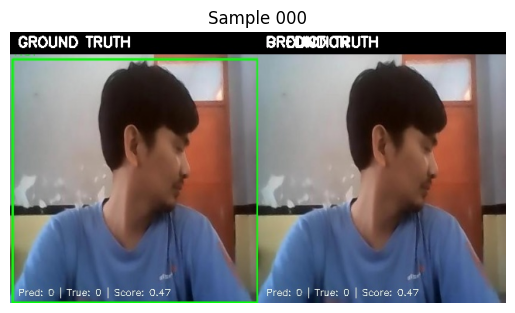

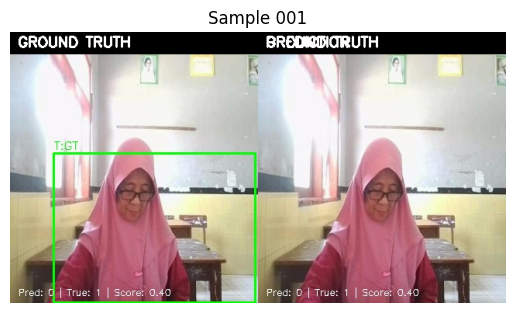

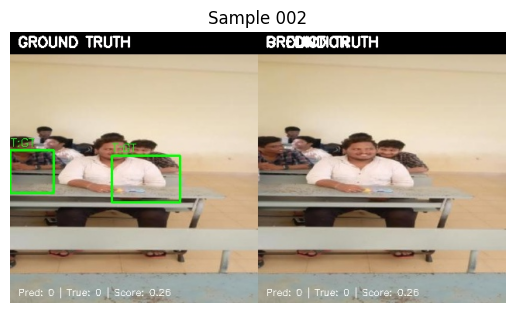

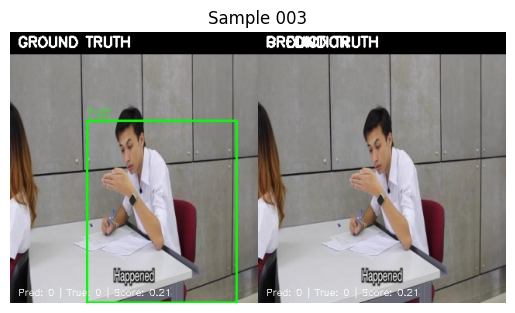

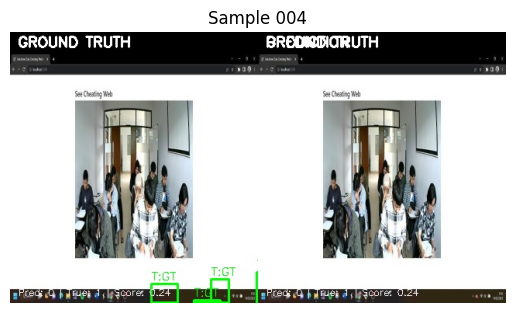

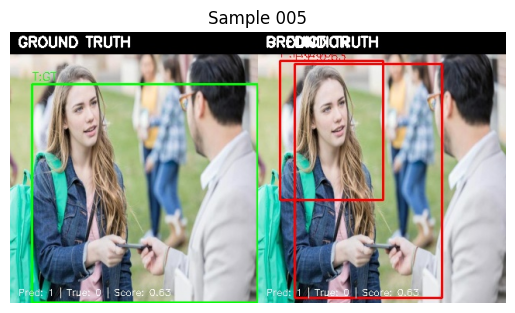

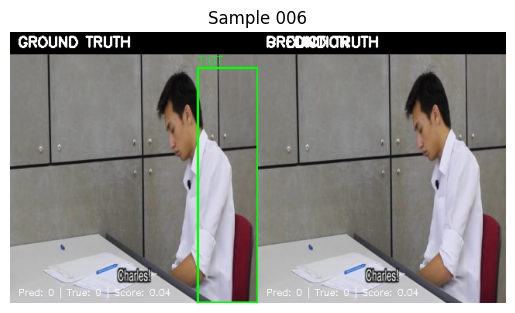

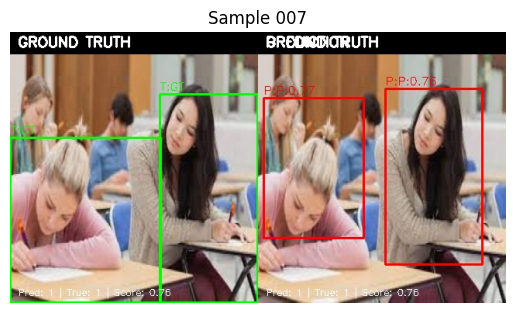

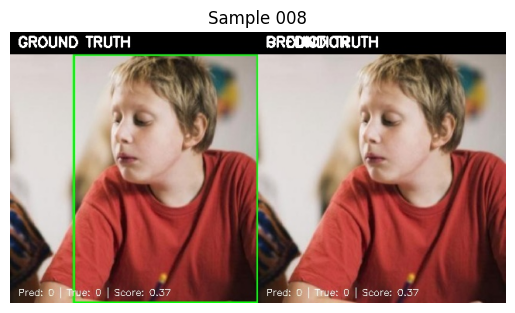

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

for i in range(9):  # Adjust range if you have more images
    img_path = f'/kaggle/working/pred_vs_true/sample_{i:03d}.jpg'

    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Sample {i:03d}')
        plt.show()
    else:
        print(f"Image not found: {img_path}")
